In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.metrics import f1_score as f1 

from sklearn.linear_model import LogisticRegression
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def get_input(data_path: str) -> pd.DataFrame:
    """
    Считывание данных и вывод основной информации о наборе данных.

    Parameters
    ----------
    data_path: str
        Название файла.

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    base_path = "Data"
    data = pd.read_csv(f"{base_path}/{data_path}")
    data.columns = [col.lower() for col in data.columns]
    print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
#считаем минимально приемлемым уровень дисбаллансе
    min_disbalance_level = 1
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    disbalance_coeff = round(disbalance_coeff / min_disbalance_level) 
    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
def calculate_permutation_importance(estimator, 
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.Series) -> pd.Series:
    """
    Расчет пермутированной важности признаков.
    """
    scores = {}
    y_pred = estimator.predict(x_valid)
    base_score = metric(y_valid, y_pred)

    for feature in x_valid.columns:
        x_valid_copy = x_valid.copy()
        x_valid_copy[feature] = np.random.permutation(x_valid_copy[feature])

        y_pred = estimator.predict(x_valid_copy)
        score = metric(y_valid, y_pred)
        scores[feature] = base_score - score

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores    

In [4]:
X_train = get_input("X_train.csv")
#X_valid = get_input("X_valid.csv")
#test_id = X_valid["id"]

X_train.csv: shape = 9997730 rows, 11 cols


In [5]:
y_train = get_input("y_train.csv")

y_train.csv: shape = 9997730 rows, 2 cols


In [6]:
X_train = X_train.merge(y_train, on="id")
#data = data.reset_index(drop=True)
X_train.head(n=2)

,id,country_code,city_id,dbm_request_time,dbm_creative_id,dbm_language,dbm_operating_system_id,dbm_browser_platform_id,dbm_device_type,dbm_mobile_model_id,domen,target
0,216627,RU,29451.0,2019-12-31 13:34:15,215162880.0,RU,1175.0,3.0,2.0,6997.0,russianfood.com,0
1,1392116,RU,29435.0,2019-12-26 09:34:49,215162880.0,RU,1212.0,6.0,2.0,1013.0,mbapp_url,0


Анализ набора данных

In [7]:
len(X_train[X_train['target'] == 1])

35150

In [8]:
len(X_train)

9997730

In [9]:
X_train['dbm_request_time'].min() 

'2019-11-25 13:44:26'

In [10]:
X_train['dbm_request_time'].max() 

'2019-12-31 22:59:39'

In [11]:
#формируем новый сокращенный df для экономии памяти
#часть данных с target=0 можно смело сократить
#на наборе данных выбираем только четные минуты (половина) и четные секунды и target = 0 (набор несбалансирован)
#но инфу о минутах и секундах не сохраняем в модели чтобы не могла переобучиться
X_train['dbm_request_time'] = pd.to_datetime(X_train['dbm_request_time'],format="%Y-%m-%d %H:%M:%S")
X_train = X_train[(X_train['dbm_request_time'].dt.second % 3 == 0) & (X_train['target'] == 0) | (X_train['target'] != 0)]

In [12]:
X_train.to_csv("./Data/X_train2.csv")

In [3]:
X_train = get_input("X_train2.csv")
X_valid = get_input("X_valid.csv")
test_id = X_valid["id"]

X_train2.csv: shape = 3355346 rows, 13 cols
X_valid.csv: shape = 6665154 rows, 11 cols


In [4]:
X_train.columns

Index(['unnamed: 0', 'id', 'country_code', 'city_id', 'dbm_request_time',
       'dbm_creative_id', 'dbm_language', 'dbm_operating_system_id',
       'dbm_browser_platform_id', 'dbm_device_type', 'dbm_mobile_model_id',
       'domen', 'target'],
      dtype='object')

In [5]:
#добавим искусственное поле, чтобы потом разделить трэйн и валид
X_train['valid'] = 0
X_valid['valid'] = 1
X_valid['target'] = -1
df = pd.concat([X_train, X_valid], axis=0)
df = df.reset_index(drop=True)
df.head(n=2)

,unnamed: 0,id,country_code,city_id,dbm_request_time,dbm_creative_id,dbm_language,dbm_operating_system_id,dbm_browser_platform_id,dbm_device_type,dbm_mobile_model_id,domen,target,valid
0,0.0,216627,RU,29451.0,2019-12-31 13:34:15,215162880.0,RU,1175.0,3.0,2.0,6997.0,russianfood.com,0,0
1,2.0,9251464,RU,NaN,2019-12-25 11:10:03,215162880.0,RU,1205.0,3.0,2.0,7973.0,mbapp_url,0,0


In [6]:
len(df['city_id'].unique())

977

In [7]:
df['city_id'].median()

29378.0

In [8]:
len(df['dbm_creative_id'].unique())

7

In [9]:
len(df['dbm_device_type'].unique())

2

In [10]:
#посмотрим пропуски
df.isnull().sum()

unnamed: 0                 6665154
id                               0
country_code                     0
city_id                    1190693
dbm_request_time                 0
dbm_creative_id                  0
dbm_language                     0
dbm_operating_system_id          0
dbm_browser_platform_id          0
dbm_device_type                  0
dbm_mobile_model_id              0
domen                            0
target                           0
valid                            0
dtype: int64

Обработка сырых данных. 

In [11]:
#обработка времени
df['dbm_request_time'] = pd.to_datetime(X_train['dbm_request_time'],format="%Y-%m-%d %H:%M:%S")
##сделать новые переменные: месяц, число, час захода в сеть
df['month'] = df['dbm_request_time'].dt.month
df['day'] = df['dbm_request_time'].dt.day
df['time'] = df['dbm_request_time'].dt.hour
df['day_of_week'] = df['dbm_request_time'].dt.weekday

In [12]:
#заполнение пропущенных значений
df.loc[df['city_id'].isnull(), 'city_id'] = df['city_id'].median()

In [13]:
df.isnull().sum()

unnamed: 0                 6665154
id                               0
country_code                     0
city_id                          0
dbm_request_time           6665154
dbm_creative_id                  0
dbm_language                     0
dbm_operating_system_id          0
dbm_browser_platform_id          0
dbm_device_type                  0
dbm_mobile_model_id              0
domen                            0
target                           0
valid                            0
month                      6665154
day                        6665154
time                       6665154
day_of_week                6665154
dtype: int64

In [14]:
df.describe(include=[np.object])

,country_code,dbm_language,dbm_mobile_model_id,domen
count,10020500,10020500,10020500,10020500
unique,2,2,100,100
top,RU,RU,7812.0,other
freq,9996743,9276371,1890235,4032016


In [15]:
#фича инжиниринг
#сделать dummy-переменные (почти все кроме city_id)
#сделать новые переменные: месяц, число, час захода в сеть

#обработка категориальных переменных
#делаем dummy-переменную вместо категориальной
pd.get_dummies(df['dbm_creative_id'])

,210330400.0,215161760.0,215162380.0,215162880.0,215163700.0,215163790.0,215164000.0
0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
10020495,0,0,0,1,0,0,0
10020496,0,0,0,1,0,0,0
10020497,0,0,0,0,0,1,0
10020498,0,0,0,1,0,0,0


In [16]:
df[['210330400','215161760','215162380','215162880','215163700','215163790','215164000']] = pd.get_dummies(df['dbm_creative_id'])

In [17]:
#удаляем старое поле
df = df.drop('dbm_creative_id', axis=1)

In [18]:
df[['0.0','1.0','3.0','6.0','1038.0']] = pd.get_dummies(df['dbm_browser_platform_id'])

In [19]:
df = df.drop('dbm_browser_platform_id', axis=1)

In [20]:
df[['dbm_device_type_1.0','dbm_device_type_3.0']] = pd.get_dummies(df['dbm_device_type'])

In [21]:
df = df.drop('dbm_device_type', axis=1)

In [22]:
df = df.drop('country_code', axis=1)

In [23]:
df[['dbm_language_Other','dbm_language_RU']] = pd.get_dummies(df['dbm_language'])

In [24]:
df = df.drop('dbm_language', axis=1)

In [25]:
df = df.drop('dbm_operating_system_id', axis=1)

In [26]:
#вместо категориального поля домен и город вставляем частотность домена, города
freq_encoder = df["domen"].value_counts(normalize=True)
df["domen_freq_enc"] = df["domen"].map(freq_encoder)
top10_domens_df = freq_encoder.sort_values().tail(10)
top10_domens_df

news.sportbox.ru    0.006176
euroki.org          0.007524
drive2.ru           0.008918
versiya.info        0.010891
yaplakal.com        0.011424
adme.ru             0.014519
cosmo.ru            0.016451
accuweather.com     0.025217
mbapp_url           0.311289
other               0.402377
Name: domen, dtype: float64

In [27]:
#вставляем частотность кликабельности домена
freq_target1 = df[df['target'] == 1]["domen"].value_counts(normalize=True)
df["rating"] = df["domen"].map(freq_target1)
top10_domens_df2 = freq_target1.sort_values().tail(10)
#10 самых кликабельных доменов
top10_domens_df2

cosmo.ru           0.004950
rustih.ru          0.005121
drive2.ru          0.005263
mixnews.lv         0.006031
ixbt.com           0.007624
versiya.info       0.009644
adme.ru            0.015363
accuweather.com    0.023073
other              0.276785
mbapp_url          0.528450
Name: domen, dtype: float64

In [28]:
prob = df[df['target'] == 1]["domen"].fillna(0).value_counts() / df["domen"].value_counts()
df["prob"] = df["domen"].map(prob)
top10_domens_df3 = prob.sort_values().tail(10)
#10 доменов c самой большой вероятностью клика если встретятся
top10_domens_df3

expert.ru           0.004986
ixbt.com            0.005190
popmech.ru          0.005745
mbapp_url           0.005955
24smi.org           0.006785
video-facts.com     0.006897
genius.com          0.006965
amalgama-lab.com    0.008321
ask.fm                   NaN
exler.ru                 NaN
Name: domen, dtype: float64

In [29]:
#подсчитываем top_10 самых популярных доменов (не забудь, что для валидационного набора это делать не надо, использовать готовый)
top10_domens = list(top10_domens_df2.index)
min_freq = top10_domens_df.min()
top10_domens

['cosmo.ru',
 'rustih.ru',
 'drive2.ru',
 'mixnews.lv',
 'ixbt.com',
 'versiya.info',
 'adme.ru',
 'accuweather.com',
 'other',
 'mbapp_url']

In [30]:
#добавление новых dummy-полей
df[top10_domens] = pd.get_dummies(df['domen'])[top10_domens]

In [31]:
df = df.drop('domen', axis=1)

In [32]:
#частотность для города
freq_encoder = df["city_id"].value_counts(normalize=True)
df["city_freq_enc"] = df["city_id"].map(freq_encoder)

In [33]:
df = df.drop('city_id', axis=1)
df = df.drop('dbm_mobile_model_id', axis=1)

In [34]:
df = df.drop(['id','dbm_request_time'], axis=1)

In [35]:
df = df.fillna(0)

In [36]:
#обработанный набор данных
df.columns

Index(['unnamed: 0', 'target', 'valid', 'month', 'day', 'time', 'day_of_week',
       '210330400', '215161760', '215162380', '215162880', '215163700',
       '215163790', '215164000', '0.0', '1.0', '3.0', '6.0', '1038.0',
       'dbm_device_type_1.0', 'dbm_device_type_3.0', 'dbm_language_Other',
       'dbm_language_RU', 'domen_freq_enc', 'rating', 'prob', 'cosmo.ru',
       'rustih.ru', 'drive2.ru', 'mixnews.lv', 'ixbt.com', 'versiya.info',
       'adme.ru', 'accuweather.com', 'other', 'mbapp_url', 'city_freq_enc'],
      dtype='object')

In [37]:
X_train = df[df['valid'] == 0] 

In [38]:
X_valid = df[df['valid'] == 1] 

In [39]:
X_train = X_train.drop('valid', axis=1)
X_valid = X_valid.drop('valid', axis=1)
X_valid = X_valid.drop('target', axis=1)

In [40]:
len(X_train.columns)

36

In [41]:
X_valid.columns

Index(['unnamed: 0', 'month', 'day', 'time', 'day_of_week', '210330400',
       '215161760', '215162380', '215162880', '215163700', '215163790',
       '215164000', '0.0', '1.0', '3.0', '6.0', '1038.0',
       'dbm_device_type_1.0', 'dbm_device_type_3.0', 'dbm_language_Other',
       'dbm_language_RU', 'domen_freq_enc', 'rating', 'prob', 'cosmo.ru',
       'rustih.ru', 'drive2.ru', 'mixnews.lv', 'ixbt.com', 'versiya.info',
       'adme.ru', 'accuweather.com', 'other', 'mbapp_url', 'city_freq_enc'],
      dtype='object')

In [42]:
len(X_train[X_train['target'] == 1])

35150

In [43]:
len(X_train)

3355346

In [44]:
X_train = X_train.fillna(0)
X_valid = X_valid.fillna(0)

In [45]:
#набор не сбалансирован! 
#балансировка
TARGET_NAME = 'target'
df_balanced = balance_df_by_target(X_train, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3320196
1    3304100
Name: target, dtype: int64

In [46]:
#сокращаем набор данных и выбираем лучшую модель на сокращенном наборе данных для экономии времени на тренировку модели.

In [47]:
df = df_balanced[df_balanced['day'] > 25]

In [48]:
X = df.drop('target', axis=1)
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.25, random_state=211)

Построение и оценка базовых моделей

Логистическая регрессия

In [49]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


TRAIN

              precision    recall  f1-score   support

           0       0.53      1.00      0.69   1260645
           1       0.00      0.00      0.00   1117252

   micro avg       0.53      0.53      0.53   2377897
   macro avg       0.27      0.50      0.35   2377897
weighted avg       0.28      0.53      0.37   2377897



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


TEST

              precision    recall  f1-score   support

           0       0.53      1.00      0.69    421012
           1       0.00      0.00      0.00    371621

   micro avg       0.53      0.53      0.53    792633
   macro avg       0.27      0.50      0.35    792633
weighted avg       0.28      0.53      0.37    792633

CONFUSION MATRIX

col_0        0
target        
0       421012
1       371621


In [50]:
pred_test_proba = model_lr.predict_proba(X_test)

In [51]:
oof_preds = roc_auc_score(y_test, pred_test_proba[:,1])
oof_preds

0.501946530150605

попробуем случайный лес (RandomForest).

In [52]:
clf = RF(max_depth=15,n_estimators=100,max_features=4,random_state=100)

In [53]:
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=100, verbose=0, warm_start=False)

In [54]:
pred = clf.predict(X_train)

In [55]:
f1(y_train, pred, average='macro')

0.6757835237480398

In [56]:
pred_test = clf.predict(X_test)

In [57]:
f1(y_test,pred_test, average='macro')

0.6747188689435573

In [58]:
pred_test_proba = clf.predict_proba(X_test)

In [59]:
oof_preds_rf = roc_auc_score(y_test, pred_test_proba[:,1])
oof_preds_rf

0.7686479902137336

XGBoost

In [60]:
%%time

model_xgb = xgb.XGBClassifier(max_depth=15, booster="gbtree",eval_metric="auc", objective="binary:logistic")

model_xgb.fit(X_train, y_train)

Wall time: 7min 50s


In [61]:
pred = model_xgb.predict(X_train)

In [62]:
f1(y_train, pred, average='macro')

0.9589289921110631

In [63]:
pred_test = model_xgb.predict(X_test)

In [64]:
f1(y_test,pred_test, average='macro')

0.9550306077013984

In [65]:
model_xgb.predict_proba(X_test)

array([[0.99784726, 0.00215273],
       [0.96524614, 0.03475386],
       [0.66090417, 0.33909583],
       ...,
       [0.7387016 , 0.26129845],
       [0.4974404 , 0.5025596 ],
       [0.6798816 , 0.32011846]], dtype=float32)

In [66]:
pred_test_proba = model_xgb.predict_proba(X_test)

In [67]:
pred_test_proba[:,0].mean()

0.5277564

In [68]:
pred_test_proba[:,1].mean()

0.47224358

In [69]:
oof_preds_xgb = roc_auc_score(y_test, pred_test_proba[:,1])
oof_preds_xgb

0.9918241764517607

Вывод: лучше всего работает XGBoost. Будем его использовать как финальную модель.

In [70]:
#подсчет важности каждого признака
perm_importance1 = calculate_permutation_importance(
    estimator=model_xgb, metric=roc_auc_score, x_valid=X_test, y_valid=y_test
)
perm_importance1[:10]

unnamed: 0        0.408177
time              0.269247
city_freq_enc     0.253820
prob              0.200609
day               0.096552
domen_freq_enc    0.069670
day_of_week       0.064250
215162880         0.056985
rating            0.033803
3.0               0.033084
dtype: float64

In [89]:
good_f = list(perm_importance1[:20].index)

In [97]:
good_f

['unnamed: 0',
 'time',
 'city_freq_enc',
 'prob',
 'day',
 'domen_freq_enc',
 'day_of_week',
 '215162880',
 'rating',
 '3.0',
 '215163790',
 '215161760',
 'dbm_language_Other',
 '6.0',
 '1038.0',
 'accuweather.com',
 '0.0',
 'dbm_device_type_1.0',
 'versiya.info',
 '210330400']

Тренировка выбранной модели

In [95]:
df = df_balanced

In [96]:
X = df[good_f] #обрезаем ненужные фичи
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.25, random_state=211)

In [98]:
%%time

model_xgb = xgb.XGBClassifier(max_depth=15, booster="gbtree",eval_metric="auc", objective="binary:logistic")

model_xgb.fit(X_train, y_train)

[12:39:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Wall time: 18min 15s


In [99]:
pred = model_xgb.predict(X_train)

In [100]:
f1(y_train, pred, average='macro')

0.9592629578569807

In [101]:
len(X_train)

4968222

In [102]:
pred_test = model_xgb.predict(X_test)

In [103]:
f1(y_test,pred_test, average='macro')

0.9550741055715115

In [104]:
model_xgb.predict_proba(X_test)

array([[7.1339691e-01, 2.8660309e-01],
       [2.2426367e-02, 9.7757363e-01],
       [3.9697826e-02, 9.6030217e-01],
       ...,
       [9.3735820e-01, 6.2641792e-02],
       [9.8420376e-01, 1.5796240e-02],
       [9.9999863e-01, 1.3442893e-06]], dtype=float32)

In [105]:
pred_test_proba = model_xgb.predict_proba(X_test)

In [106]:
pred_test_proba[:,0].mean()

0.49870116

In [107]:
pred_test_proba[:,1].mean()

0.50129884

In [108]:
y_test

2120451    0
4197408    1
6259010    1
4842812    1
5377195    1
          ..
5836732    1
5585224    1
2350672    0
1994835    0
81542      0
Name: target, Length: 1656074, dtype: int64

In [109]:
oof_preds_xgb = roc_auc_score(y_test, pred_test_proba[:,1])
oof_preds_xgb

0.9910818626203324

Получение итоговых предсказаний на тестовом наборе

In [110]:
X_valid.columns

Index(['unnamed: 0', 'month', 'day', 'time', 'day_of_week', '210330400',
       '215161760', '215162380', '215162880', '215163700', '215163790',
       '215164000', '0.0', '1.0', '3.0', '6.0', '1038.0',
       'dbm_device_type_1.0', 'dbm_device_type_3.0', 'dbm_language_Other',
       'dbm_language_RU', 'domen_freq_enc', 'rating', 'prob', 'cosmo.ru',
       'rustih.ru', 'drive2.ru', 'mixnews.lv', 'ixbt.com', 'versiya.info',
       'adme.ru', 'accuweather.com', 'other', 'mbapp_url', 'city_freq_enc'],
      dtype='object')

In [111]:
#валидационный набор надо обработать точно также как обучающий
X_valid = X_valid[good_f] #обрезаем ненужные фичи

In [112]:
pred_valid_proba = model_xgb.predict_proba(X_valid)

In [113]:
pred_valid_proba

array([[9.9919420e-01, 8.0579874e-04],
       [9.9978989e-01, 2.1011736e-04],
       [9.9995661e-01, 4.3411135e-05],
       ...,
       [9.9971825e-01, 2.8174731e-04],
       [9.9865568e-01, 1.3443436e-03],
       [9.9715233e-01, 2.8476447e-03]], dtype=float32)

In [114]:
pred_valid_proba[:,0].mean()

0.97671336

In [115]:
pred_valid_proba[:,1].mean()

0.023286365

In [116]:
y_pred = pd.DataFrame({
    "ID": test_id,
    "TARGET": pred_valid_proba[:,1]
})
y_pred.to_csv("./Data/pred_proba_VZinchenko.csv",index=False)

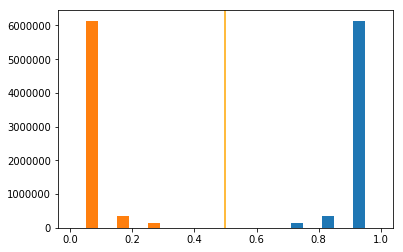

In [117]:
plt.hist(pred_valid_proba)
_ = plt.axvline(x=0.5, color='orange')